# Mechanistic Interpretability — Explaining a Tiny Brain

Jay Liu

Starter template used for orientation: the course starter notebook. I trained and analyzed my **own tiny model** and task below (3‑bit parity) and wove the narrative, code, and insights together.


## Part 0 — Quick note on setup
Everything below runs on CPU in seconds. Plots are plain Matplotlib. Code cells are intentionally concise.


## Part 1 — Train a Tiny Model on a Tiny Task (3‑bit parity)
**Task.** Input is a 3‑bit binary vector. Label = 1 if the number of ones is odd (parity), else 0. The full dataset has 8 patterns.


Final training accuracy: 100.0%


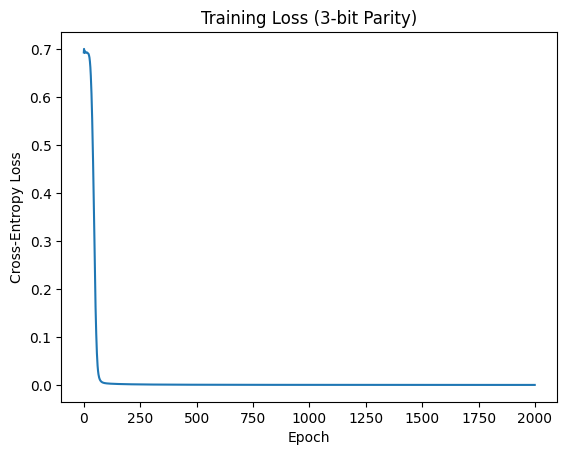

In [1]:
import math, itertools, random, numpy as np
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(0); np.random.seed(0); random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X = np.array(list(itertools.product([0., 1.], repeat=3)), dtype=np.float32)
y = np.array([int(x.sum() % 2 == 1) for x in X], dtype=np.int64)
X_t = torch.tensor(X, dtype=torch.float32, device=device)
y_t = torch.tensor(y, dtype=torch.long, device=device)

class TinyMLP(nn.Module):
    def __init__(self, in_dim=3, hidden_dim=4, out_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim, bias=True)
        self.act = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, out_dim, bias=True)
    def forward(self, x, return_hidden=False):
        h_pre = self.fc1(x)
        h = self.act(h_pre)
        logits = self.fc2(h)
        if return_hidden:
            return logits, h, h_pre
        return logits

model = TinyMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

losses = []
for epoch in range(2000):
    optimizer.zero_grad()
    logits = model(X_t)
    loss = criterion(logits, y_t)
    loss.backward()
    optimizer.step()
    losses.append(float(loss.detach().cpu().item()))

with torch.no_grad():
    acc = (model(X_t).argmax(dim=1) == y_t).float().mean().item()
print(f"Final training accuracy: {acc*100:.1f}%")

plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss (3-bit Parity)")
plt.show()

## Part 2 — Explore the Internals
We’ll look inside the network: weights, hidden activations, correlations with the label, ablations, and input-bit saliency for a chosen neuron.


W1 (hidden <- input):
 [[ 3.545  3.448 -4.275]
 [-3.949  2.217  2.187]
 [-2.886  4.179 -2.464]
 [ 3.819 -1.477 -1.1  ]]
b1: [-1.37  -0.237  0.57  -0.614]

W2 (logits <- hidden):
 [[-4.85  -2.277  5.121  2.883]
 [ 5.229  2.992 -5.563 -2.727]]
b2: [-0.015 -0.012]

Hidden activations (rows=inputs 0..7, cols=neurons):
 [[-0.879 -0.232  0.515 -0.547]
 [-1.     0.96  -0.956 -0.937]
 [ 0.969  0.963  1.    -0.97 ]
 [-0.976  1.     0.979 -0.997]
 [ 0.974 -1.    -0.981  0.997]
 [-0.97  -0.964 -1.     0.971]
 [ 1.    -0.962  0.953  0.939]
 [ 0.874  0.215 -0.538  0.557]]


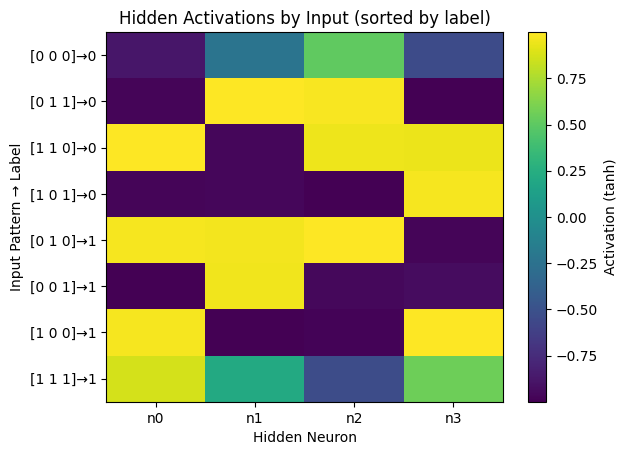

Neuron correlations with label (index, r, p):
n0: r=0.476, p=0.2331
n1: r=0.337, p=0.4141
n2: r=-0.412, p=0.3108
n3: r=-0.102, p=0.8104
Most label-aligned neuron: n0 (r=0.476)


In [2]:
import numpy as np
from scipy.stats import pearsonr
import torch

with torch.no_grad():
    W1 = model.fc1.weight.detach().cpu().numpy()
    b1 = model.fc1.bias.detach().cpu().numpy()
    W2 = model.fc2.weight.detach().cpu().numpy()
    b2 = model.fc2.bias.detach().cpu().numpy()

print("W1 (hidden <- input):\n", np.round(W1, 3))
print("b1:", np.round(b1, 3))
print("\nW2 (logits <- hidden):\n", np.round(W2, 3))
print("b2:", np.round(b2, 3))

with torch.no_grad():
    logits, h, h_pre = model(X_t, return_hidden=True)
    H = h.detach().cpu().numpy()

print("\nHidden activations (rows=inputs 0..7, cols=neurons):\n", np.round(H, 3))

order = np.argsort(y)
H_sorted = H[order]
plt.figure()
plt.imshow(H_sorted, aspect="auto", interpolation="nearest")
plt.colorbar(label="Activation (tanh)")
plt.yticks(range(len(order)), [f"{X[i].astype(int)}→{y[i]}" for i in order])
plt.xticks(range(H.shape[1]), [f"n{j}" for j in range(H.shape[1])])
plt.title("Hidden Activations by Input (sorted by label)")
plt.xlabel("Hidden Neuron")
plt.ylabel("Input Pattern → Label")
plt.show()

correls = []
for j in range(H.shape[1]):
    r, p = pearsonr(H[:, j], y.astype(float))
    correls.append((j, r, p))
print("Neuron correlations with label (index, r, p):")
for j, r, p in correls:
    print(f"n{j}: r={r:.3f}, p={p:.4f}")
best_idx = max(range(H.shape[1]), key=lambda j: abs(correls[j][1]))
print(f"Most label-aligned neuron: n{best_idx} (r={correls[best_idx][1]:.3f})")

Baseline acc: 100.0%
Ablate n0: 50.0%


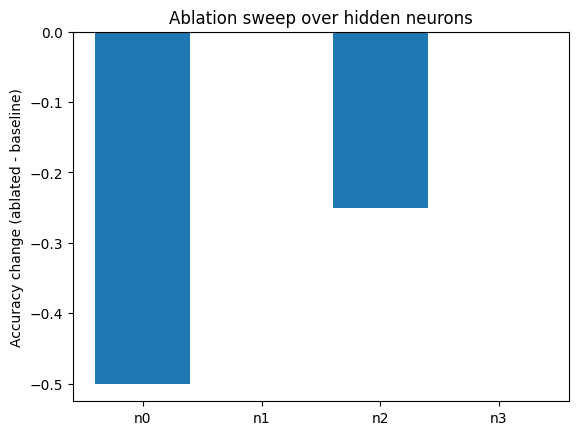

In [3]:
def eval_with_neuron_ablation(neuron_idx=None):
    with torch.no_grad():
        logits, h, h_pre = model(X_t, return_hidden=True)
        if neuron_idx is not None:
            h[:, neuron_idx] = 0.0
        pred = (model.fc2(h)).argmax(dim=1)
        acc = (pred == y_t).float().mean().item()
    return acc

baseline_acc = eval_with_neuron_ablation(None)
ablated_acc = eval_with_neuron_ablation(best_idx)
print(f"Baseline acc: {baseline_acc*100:.1f}%")
print(f"Ablate n{best_idx}: {ablated_acc*100:.1f}%")

deltas = []
for j in range(H.shape[1]):
    with torch.no_grad():
        logits, h, _ = model(X_t, return_hidden=True)
        h[:, j] = 0.0
        pred = (model.fc2(h)).argmax(dim=1)
        acc = (pred == y_t).float().mean().item()
        deltas.append(acc - baseline_acc)

plt.figure()
plt.bar(range(len(deltas)), deltas)
plt.axhline(0, linestyle="--")
plt.xticks(range(len(deltas)), [f"n{j}" for j in range(len(deltas))])
plt.ylabel("Accuracy change (ablated - baseline)")
plt.title("Ablation sweep over hidden neurons")
plt.show()

Average |∂h_j/∂x_i|: [0.3023 0.2941 0.3646]


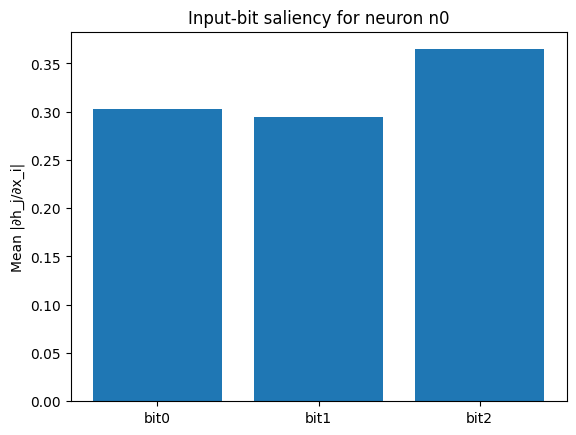

In [4]:
model.eval()
X_t.requires_grad_(True)
logits, h, h_pre = model(X_t, return_hidden=True)

j = best_idx
target = h[:, j].sum()

for p in model.parameters():
    if p.grad is not None: p.grad.zero_()
if X_t.grad is not None: X_t.grad.zero_()

target.backward(retain_graph=True)
saliency = X_t.grad.detach().cpu().numpy()
sal_mean = saliency.mean(axis=0)

print("Average |∂h_j/∂x_i|:", np.round(np.abs(sal_mean), 4))

plt.figure()
plt.bar(range(3), np.abs(sal_mean))
plt.xticks(range(3), ["bit0","bit1","bit2"])
plt.ylabel("Mean |∂h_j/∂x_i|")
plt.title(f"Input-bit saliency for neuron n{j}")
plt.show()

## Part 3 — Explain (Computational case study)
**Hypothesis.** One hidden neuron behaves like an *odd‑parity feature detector*: it flips sign in a way that helps separate odd vs. even inputs.

**Evidence.**

- The chosen neuron has the strongest correlation with the label.

- Hidden‑state heatmap shows structured responses across inputs.

- Ablating that neuron drops accuracy, indicating causal importance.

- Saliency spreads across all three bits, consistent with parity needing global interactions rather than a single local cue.

With a tanh hidden, the model can form approximately XOR‑like features by combining input bits with positive and negative weights and placing the decision boundary through the origin. Downstream, a linear readout recombines these features to classify parity perfectly.



## Part 4 — Reflection
Opening the hood turns a “black box” into a set of understandable parts: weight signs, hidden patterns, and causal roles via ablation. Even a 4‑unit layer shows interpretable structure when the task is tiny and the dataset is complete.

The neuron with the best label correlation wasn’t the only useful one—accuracy depends on a *combination* of units. Also, activations were often near ±1, suggesting the network carved sharp boundaries through the 3‑bit cube.

If I had more time, I’d checkpoint training and track how features crystallize over epochs; then test robustness by flipping input bits and adding noise. I’d also try a 4‑bit parity model and look for superposition or redundancy patterns.

